# Compositional Contextual Expert Bandits [CCEB]

## Part 1: Defining The Inference System

In [1]:
import torch
# Set so that each particle will only use one thread
torch.set_num_threads(1)
torch.set_num_interop_threads(1)
# set torch print options, including line width
torch.set_printoptions(precision=4, sci_mode=False, linewidth=250)

import torch.distributions as D
import matplotlib.pyplot as plt
from copy import deepcopy
from concurrent.futures import ProcessPoolExecutor

In [2]:
from conjugates import ConjugateCategorical, ConjugateGaussian
from crp import CRP

/scratch/venvs/generic312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Helper functions to simplify syntax of sampling categorical distributions

In [3]:
class Categorical2D():
    def __init__(self, probs: torch.Tensor):
        assert probs.dim() == 2, "probs must be a 2D tensor"
        self.dim1, self.dim2 = probs.shape
        #assert torch.sum(probs) == 1.0, "probs must sum to 1"
        self.probs2d = probs  
        self.probs = probs.flatten()

    def sample(self):
        idx = D.Categorical(probs=self.probs).sample().item()
        i = idx // self.dim2
        j = idx % self.dim2
        
        return i, j
    
def cat_sample(probs: torch.Tensor):
    """
    Sample from a categorical distribution defined by the given probabilities.
    probs: 1D tensor of probabilities
    returns: sampled index
    """
    normalized_probs = probs / torch.sum(probs)
    return D.Categorical(probs=normalized_probs).sample().item()

def cat2D_sample(probs: torch.Tensor):
    """
    Sample from a 2D categorical distribution defined by the given probabilities.
    probs: 2D tensor of probabilities
    returns: sampled indices (i, j)
    """
    cat2d = Categorical2D(probs)
    return cat2d.sample()

### Main Particle Class

In [4]:
class Particle():
    """
    Main class implementing a single particle in the CCEB model
    """
    def __init__(self, hyp_gamma, hyp_alpha_o=1.0, hyp_alpha_r=1.0):
        
        self.hyp_gamma = hyp_gamma
        self.hyp_alpha_o = hyp_alpha_o
        self.hyp_alpha_r = hyp_alpha_r

        self.state_space = [0, 1]
        self.state_probs = torch.tensor([0.5, 0.5])
        self.n_states = len(self.state_space)

        self.context_o_space = []
        self.context_r_space = []

        self.observation_models = [[] for _ in self.state_space]
        self.reward_models = [[] for _ in self.state_space]

        self.context_o_CRP = CRP(hyp_alpha=self.hyp_alpha_o)
        self.context_r_CRP = CRP(hyp_alpha=self.hyp_alpha_r)

        self.prev_o_context = 0
        self.prev_r_context = 0

        self.novel_obs_model = ConjugateGaussian(**conjugate_gaussian_standard)
        self.novel_reward_model = ConjugateCategorical(alpha0=alpha_0_standard)

    @property
    def n_contexts_o(self):
        return len(self.context_o_space)

    @property
    def n_contexts_r(self):
        return len(self.context_r_space)

    def observation_likelihood(self, o_t):
        """
        P(o_t | s_t=i, c_o_t=j)

        What is the likelihood of the observation o_t under each state i and observation context j?
        """
        likelihoods = torch.zeros(self.n_states, (self.n_contexts_o + 1))

        for i in range(self.n_states):
            for j in range(self.n_contexts_o):
                """
                P(o_t | s_t=i, c_o_t=j) = ∫ P(o_t | Ω_i,j) P(Ω_i,j| ... ) dΩ_i,j            Multivariate Student-t
                """
                likelihoods[i, j] = self.observation_models[i][j].predictive_likelihood(o_t)
            """
            P(o_t | s_t=i, c_o_t=new) = ∫ P(o_t | Ω_i,new) P(Ω_i,new| ... ) dΩ_i,new        Multivariate Student-t
            """
            likelihoods[i, -1] = self.novel_obs_model.predictive_likelihood(o_t)

        return likelihoods

    def marginal_evidence(self, likelihoods):
        """
        P(o_t |c_o_{t-1}, j_t=i) = Σ_s_t Σ_c_o_t P(o_t | S_t, C_o_t) P(S_t) P(C_o_t |c_o_{t-1}, j_t=i)

        What is the marginal likelihood of the observation o_t under each value of the jump variable j_t?

            This is used to sample the jump variable j_t to make proposals more efficient.
        """
        
        """
        P(o_t |c_o_{t-1}, j_t=0) = Σ_s_t P(o_t | S_t, c_o_{t-1}) P(S_t)
        """
        # Special case for first time step, a jump must be made, since there is no previous context
        if self.n_contexts_o == 0: 
            lj0 = 0.0
        # Otherwise, marginal for not jumping is the likelihood under the previous context, weighted by state probabilities
        else:
            lj0 = torch.zeros(self.n_states)
            for i in range(self.n_states):
                lj0[i] = self.state_probs[i] * likelihoods[i, self.prev_o_context]
            lj0 = torch.sum(lj0)

        """
        P(o_t |c_o_{t-1}, j_t=1) = Σ_s_t Σ_c_o_t P(o_t | S_t, C_o_t) P(S_t) P(C_o_t | θ^o)
        """
        lj1 = torch.zeros(self.n_states)
        for i in range(self.n_states):
            lj1[i] = self.state_probs[i] * torch.sum(likelihoods[i,:]*self.context_o_CRP.probabilities)
        lj1 = torch.sum(lj1)

        return lj0, lj1
    
    def sample_jump(self, likelihoods):
        """
        j_t ~ P(J_t | o_t, ...) ∝ P(o_t | J_t, ...) P(J_t)

        Sample the jump variable j_t. 0 = no jump, 1 = jump
        """

        lj0, lj1 = self.marginal_evidence(likelihoods)
        j_probs = torch.tensor([lj0*(1-self.hyp_gamma), lj1*self.hyp_gamma])

        return cat_sample(j_probs)

    def sample_state_context_o(self, likelihoods, j_t):
        """
        s_t, c_o_t ~ P(S_t, C_o_t | o_t, j_t, c_o_{t-1} ...) ∝ P(o_t | S_t, C_o_t) P(S_t) P(C_o_t | j_t, c_o_{t-1})

        Sample the latent state 
        """
        if j_t == 0:
            """
            s_t, c_o_t ~ P(S_t, C_o_t | o_t, j_t=0, ...) ∝ P(o_t | S_t, C_o_t) P(s_t) δ (C_o_t, c_o_{t-1})
            """
            s_t_probs = torch.zeros(self.n_states)
            for i in range(self.n_states):
                s_t_probs[i] = self.state_probs[i] * likelihoods[i, self.prev_o_context]

            s_t = cat_sample(s_t_probs)    
            c_o_t = self.prev_o_context        

        elif j_t == 1:
            """
            s_t, c_o_t ~ P(S_t, C_o_t | o_t, j_t=1, ...) ∝ P(o_t | S_t, C_o_t) P(S_t) P(C_o_t | θ^o) 
            """
            joint_probs = torch.zeros((self.n_states, self.n_contexts_o + 1))
            for i in range(self.n_states):
                # Existing contexts
                for j in range(self.n_contexts_o):
                    joint_probs[i, j] = self.state_probs[i] * likelihoods[i, j] * self.context_o_CRP.probabilities[j]
                # New context
                joint_probs[i, -1] = self.state_probs[i] * likelihoods[i, -1] * self.context_o_CRP.probabilities[-1]

            s_t, c_o_t = cat2D_sample(joint_probs)

        else:
            raise ValueError("j_t must be 0 or 1")

        return s_t, c_o_t
    
    def sample_context_r(self, j_t):
        """
        c_r_t ~ P(c_r_t | j_t, ...) = P(c_r_t | θ^r) if j_t=1 else δ(c_r_t, c_r_{t-1})

        Sample the reward context given the jump variable
        """

        if j_t == 0:
            c_r_t = self.prev_r_context

        else: # if j == 1
            c_r_t = self.context_r_CRP.sample()

        return c_r_t

    def sample_latent_states(self, o_t):
        """
        s_t, c_o_t, c_r_t, j_t ~ P(S_t, C_o_t, C_r_t, J_t | o_t, ...)

        Sample the latent state, observation context, reward context, and jump variable given the new observation o_t
        """
        likelihoods = self.observation_likelihood(o_t)

        """
        P(J_t | o_t, ...) ∝ P(o_t | J_t, ...) P(J_t)
        """
        j_t = self.sample_jump(likelihoods)
        """
        P(S_t, S_o_t | o_t, j_t, ...) ∝ P(o_t | S_t, C_o_t) P(S_t) P(C_o_t | j_t, c_o_{t-1})
        """
        s_t, c_o_t = self.sample_state_context_o(likelihoods, j_t)
        # Handle new observation context if needed
        if c_o_t == self.n_contexts_o: 
            self.context_o_space.append(self.n_contexts_o)
            for i, state in enumerate(self.state_space):
                self.observation_models[i].append(ConjugateGaussian(**conjugate_gaussian_standard))
        """
        P(C_r_t | j_t, ...) = P(C_r_t | θ^r) if j_t=1 else δ(c_r_t, c_r_{t-1})
        """
        c_r_t = self.sample_context_r(j_t)
        # Handle new reward context if needed
        if c_r_t == len(self.context_r_space): 
            self.context_r_space.append(len(self.context_r_space))
            for i, state in enumerate(self.state_space):
                self.reward_models[i].append(ConjugateCategorical(alpha0=alpha_0_standard))

        return s_t, c_o_t, c_r_t, j_t
    
    
    def update_o_params(self, s_t, c_o_t, o_t, j_t):
        """
        Update the observation models and the observation context CRP
        """       
        
        """
        Update the observation model parameter distribution Ω_i,j based on the new observation o_t (handled internally by the conjugate model class)
        """
        self.observation_models[s_t][c_o_t].update(o_t)
        
        """
        Update the CRP counts θ^o if a jump was made
        """
        if j_t == 1.0:
            self.context_o_CRP.update_single(c_o_t)
            

    def sample_action(self, s_t, c_r_t):
        """
        Thompson sampling action selection based on the reward model for the current state and reward context
        """

        predicted_rewards = self.reward_models[s_t][c_r_t].sample_posterior_distribution()
    
        greedy_a_t = torch.argmax(predicted_rewards).item()

        # make epsilon-greedy here if desired
        if torch.rand(1).item() < 0.01:
            # choose random action from [0, 1, 2, 3]
            a_t = torch.randint(0, 4, (1,)).item()
        else:
            a_t = greedy_a_t

        return a_t


    def reward_likelihood(self, r_t, s_t, a_t, c_r_t):
        """
        P(r_t={0,1} | s_t=i, c_r_t=k, a_t=a, ϒ) 

        Compute the predictive likelihood of a reward r_t given the state s_t, reward context c_r_t, action a_t, and the reward model parameter distribution ϒ_i,k
        """
        if r_t == 1.0:
            return self.reward_models[s_t][c_r_t].predictive_likelihood(a_t)
        else:
            return 1.0 - self.reward_models[s_t][c_r_t].predictive_likelihood(a_t)
        

    def update_r_params(self, c_r_t, s_t, a_t, r_t, j_t):
        """
        Update the reward models and the reward context CRP
        """
        
        """
        Update the reward model parameter distribution ϒ_i,j based on the action taken and reward received
        """
        # If the action was optimal, update the model with the actual action taken
        if r_t == 1.0:
            self.reward_models[s_t][c_r_t].update(a_t)
        # If the action was not optimal, sample an alternative action and update the model with that
        else:
            probs = self.reward_models[s_t][c_r_t].posterior_params()['alpha_n']

            probs[a_t] = 0.0
            probs = probs / probs.sum()
            alt_a_t = D.Categorical(probs=probs).sample().item()

            self.reward_models[s_t][c_r_t].update(alt_a_t)
        

        """
        Update the CRP counts θ^r if a jump was made
        """
        if j_t == 1.0:
            self.context_r_CRP.update_single(c_r_t)

    def predictive_evidence(self, o_t):
        """
        P(o_t | ...) =

        Compute the marginal likelihood of the observation o_t under the particle's model
        """
        likelihoods = self.observation_likelihood(o_t)
        lj0, lj1 = self.marginal_evidence(likelihoods)
        p_evidence = (1 - self.hyp_gamma) * lj0 + self.hyp_gamma * lj1
        
        return p_evidence


# Standard prior parameters for conjugate models
conjugate_gaussian_standard = {
    'mu0': torch.tensor([0.0, 0.0, 0.0]),
    'kappa0': 0.1,
    'nu0': 4.0,
    'Lambda0': torch.eye(3) * 1.0 
}
alpha_0_standard = torch.tensor([0.1, 0.1, 0.1, 0.1])

### Ensemble Class implementing filtering steps

In [5]:
class Ensemble():
    def __init__(self, N, hyp_gamma=0.05, hyp_alpha_o=1.0, hyp_alpha_r=1.0):
        self.N = N
        self.particles = [Particle(hyp_gamma, hyp_alpha_o, hyp_alpha_r) for _ in range(N)]
        self.weights = torch.ones(N) / N

        self.vec_s_t    = torch.zeros(N, dtype=torch.long)
        self.vec_c_o_t  = torch.zeros(N, dtype=torch.long)
        self.vec_c_r_t  = torch.zeros(N, dtype=torch.long)
        self.vec_j_t    = torch.zeros(N, dtype=torch.long)

    def resample_particles(self):
        """
        Resample particles according to their weights
        """
        # Normalise weights
        self.weights /= torch.sum(self.weights)
        
        # Resample particles according to weights
        indices = D.Categorical(probs=self.weights).sample((self.N,))
        self.particles = [deepcopy(self.particles[i]) for i in indices]
        
        # Reset weights to uniform after resampling
        self.weights = torch.ones(self.N) / self.N

    def before_action(self, o_t):
        """
        Before an action is taken, process the new observation o_t
        """
        print('> observation:', o_t)

        # 1) Resample particles based on predictive evidence (auxiliary particle filter)
        for i, p in enumerate(self.particles):
            self.weights[i] = p.predictive_evidence(o_t)

        # 2) Sample latent variables and update observation models
        for i, particle in enumerate(self.particles):
            s_t, c_o_t, c_r_t, j_t = particle.sample_latent_states(o_t)

            self.vec_s_t[i]     = s_t
            self.vec_c_o_t[i]   = c_o_t
            self.vec_j_t[i]     = j_t
            self.vec_c_r_t[i]   = c_r_t

            particle.update_o_params(s_t, c_o_t, o_t, j_t)
           
    def select_action(self):
        """
        Select an action
        """
        actions = torch.zeros(self.N, dtype=torch.long)
        for i, particle in enumerate(self.particles):
            actions[i] = particle.sample_action(self.vec_s_t[i], self.vec_c_r_t[i])

        selected_action = actions[D.Categorical(probs=self.weights).sample().item()]

        print(actions)

        return selected_action, actions

    def after_action(self, a_t, r_t):
        """
        Update the model after an action a_t is taken and reward r_t is received
        """
        for i, particle in enumerate(self.particles):
            self.weights[i] = particle.reward_likelihood(r_t, self.vec_s_t[i], a_t, self.vec_c_r_t[i])
            particle.update_r_params(self.vec_c_r_t[i], self.vec_s_t[i], a_t, r_t, self.vec_j_t[i])

            particle.prev_o_context = self.vec_c_o_t[i]
            particle.prev_r_context = self.vec_c_r_t[i]

        self.resample_particles()


## Part 2: Defining the experiment

### Define the various contexts that can be encountered

In [6]:
NOISE = 0.02

dist_c_0_s_0 = D.MultivariateNormal(loc=torch.tensor([1.0, 0.0, 0.0]), covariance_matrix=torch.eye(3)*NOISE)
dist_c_0_s_1 = D.MultivariateNormal(loc=torch.tensor([-1.0, 0.0, 0.0]), covariance_matrix=torch.eye(3)*NOISE)
dist_c_1_s_0 = D.MultivariateNormal(loc=torch.tensor([0.0, 1.0, 0.0]), covariance_matrix=torch.eye(3)*NOISE)
dist_c_1_s_1 = D.MultivariateNormal(loc=torch.tensor([0.0, -1.0, 0.0]), covariance_matrix=torch.eye(3)*NOISE)
dist_c_2_s_0 = D.MultivariateNormal(loc=torch.tensor([0.0, 0.0, 1.0]), covariance_matrix=torch.eye(3)*NOISE)
dist_c_2_s_1 = D.MultivariateNormal(loc=torch.tensor([0.0, 0.0, -1.0]), covariance_matrix=torch.eye(3)*NOISE)

def generate_observation(true_c_o, true_s):
    """
    Three possible observation contexts
    """
    if true_c_o == 0:
        if true_s == 0:
            return dist_c_0_s_0.sample()
        else:
            return dist_c_0_s_1.sample()
    elif true_c_o == 1:
        if true_s == 0:
            return dist_c_1_s_0.sample()
        else:
            return dist_c_1_s_1.sample()
    elif true_c_o == 2:
        if true_s == 0:
            return dist_c_2_s_0.sample()
        else:
            return dist_c_2_s_1.sample()
    else:
        raise ValueError("true_c must be 0, 1, or 2")


def generate_reward(true_s, a_t, true_c_r):
    """
    Two possible reward contexts
    """
    
    if true_c_r == 0:
        if true_s == 0:
            return 1.0 if a_t == 0 else 0.0
        else:
            return 1.0 if a_t == 1 else 0.0
    elif true_c_r == 1:
        if true_s == 0:
            return 1.0 if a_t == 2 else 0.0
        else:
            return 1.0 if a_t == 3 else 0.0
    else:
        raise ValueError("true_s must be 0 or 1")

#### Definte a series of trials in the same context

In [7]:
# Initialize history buffers
context_o_hist = []
context_r_hist = []
actions_hist = []
jumps_hist = []
true_rewarding_actions = []


def batched_trials(ensemble: Ensemble, true_c_o_t, true_c_r_t, n_steps=50):
    """
    Run a batch of trials with the given context combination.
    """
    for i in range(n_steps):
        # Sample state and observation
        true_s_t = cat_sample(torch.tensor([0.5, 0.5]))
        o_t = generate_observation(true_c_o_t, true_s_t)
        
        # Process observation
        ensemble.before_action(o_t)    
        
        # Select action
        a_t, actions = ensemble.select_action()
        
        # Generate reward
        r_t = generate_reward(true_s_t, a_t, true_c_r_t)
        
        # Update model
        ensemble.after_action(a_t, r_t)
        
        # Record keeping
        context_o_hist.append(ensemble.vec_c_o_t.clone())
        jumps_hist.append(ensemble.vec_j_t.clone())
        actions_hist.append(actions.clone())
        if true_c_r_t == 0:
            true_rewarding_actions.append(0 if true_s_t == 0 else 1)
        elif true_c_r_t == 1:
            true_rewarding_actions.append(2 if true_s_t == 0 else 3)
        context_r_hist.append(ensemble.vec_c_r_t.clone())

## Part 3: Simulation and Results

#### Simulation

In [8]:
# Initialize ensemble
ensemble = Ensemble(N=250, hyp_gamma=0.1, hyp_alpha_o=0.2, hyp_alpha_r=0.15)

# Run 50 trials in context (c_o=0, c_r=0)
batched_trials(ensemble, true_c_o_t=0, true_c_r_t=0, n_steps=50)
# Run 50 trials in context (c_o=1, c_r=0)
batched_trials(ensemble, true_c_o_t=1, true_c_r_t=0, n_steps=50)
# Run 50 trials in context (c_o=2, c_r=1)
batched_trials(ensemble, true_c_o_t=2, true_c_r_t=1, n_steps=50)
# Run 50 trials in context (c_o=0, c_r=1)
batched_trials(ensemble, true_c_o_t=0, true_c_r_t=1, n_steps=50)

> observation: tensor([ 0.9340,  0.0567, -0.3054])
tensor([3, 0, 2, 2, 1, 1, 0, 0, 1, 0, 3, 3, 3, 1, 2, 2, 1, 3, 2, 2, 1, 3, 3, 0, 0, 1, 2, 2, 2, 3, 2, 3, 0, 1, 3, 2, 2, 1, 3, 1, 2, 0, 3, 0, 2, 3, 0, 3, 1, 1, 3, 2, 1, 2, 1, 2, 1, 1, 3, 0, 3, 2, 0, 2, 3, 1, 1, 3, 3, 0, 3, 2, 3, 0, 2, 1, 3, 1, 1, 1, 3,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 3, 1, 2, 2, 1, 1, 1, 0, 0, 0, 0, 0, 1, 3, 1, 2, 3, 3, 3, 0, 0, 2, 3, 0, 2, 2, 3, 0, 0, 1, 1, 1, 3, 1, 0, 1, 3, 1, 3, 2, 1, 3, 1, 0, 0, 3, 1, 1, 2, 2, 1, 0, 0, 2, 1, 3, 1, 3, 0, 3, 2, 3, 3, 1, 3, 2, 3, 0, 3, 0,
        1, 2, 3, 3, 3, 0, 1, 3, 3, 1, 0, 2, 2, 3, 2, 2, 3, 1, 2, 2, 2, 3, 0, 0, 0, 0, 0, 1, 3, 0, 2, 1, 1, 3, 2, 2, 3, 0, 1, 0, 3, 1, 3, 2, 3, 0, 3, 1, 3, 2, 3, 1, 1, 0, 3, 1, 1, 1, 2, 0, 1, 1, 3, 1, 3, 1, 1, 3, 0, 3, 2, 1, 2, 0, 1, 1, 0, 2, 2, 2, 3,
        1, 2, 1, 2, 1, 2, 3])
> observation: tensor([ 1.0683, -0.0626,  0.0601])
tensor([0, 0, 3, 3, 0, 2, 3, 2, 3, 0, 0, 1, 2, 3, 1, 3, 3, 3, 1, 0, 0, 3, 3, 0, 3, 2, 0, 3, 1, 1, 0, 0, 2, 1, 0, 3,

#### Sanity check of inferred parameters

In [9]:
for particle in ensemble.particles:
    print(f"\n>> Particle {particle}:\n")
    
    for i, state in enumerate(particle.state_space):
        for j, context in enumerate(particle.context_o_space):
            print(f"State {state}, Observ Context {context}, Observation Model Params: df: {particle.observation_models[i][j]._predictive_distribution_params()['df']}, loc: {particle.observation_models[i][j]._predictive_distribution_params()['loc']}")
    print()
    for i, state in enumerate(particle.state_space):
        for j, context in enumerate(particle.context_r_space):
            print(f"State {state}, Reward Context {context}, Reward Model Alpha: {particle.reward_models[i][j]._predictive_distribution_params()}, Posterior Params: {particle.reward_models[i][j].posterior_params()}")

    print()
    # print the CRP probabilities
    print("Observation Context CRP Probabilities:", particle.context_o_CRP.probabilities, "CRP counts:", particle.context_o_CRP.counts)
    print("Reward Context CRP Probabilities:", particle.context_r_CRP.probabilities, "CRP counts:", particle.context_r_CRP.counts)


>> Particle <__main__.Particle object at 0x7c4464387ad0>:

State 0, Observ Context 0, Observation Model Params: df: 52.0, loc: tensor([ 0.9979, -0.0597, -0.0257])
State 0, Observ Context 1, Observation Model Params: df: 22.0, loc: tensor([-0.0380,  1.0444,  0.0175])
State 0, Observ Context 2, Observation Model Params: df: 29.0, loc: tensor([-0.0278,  0.0265,  0.9891])
State 1, Observ Context 0, Observation Model Params: df: 52.0, loc: tensor([-0.9850,  0.0097, -0.0472])
State 1, Observ Context 1, Observation Model Params: df: 32.0, loc: tensor([-0.0535, -0.9924, -0.0081])
State 1, Observ Context 2, Observation Model Params: df: 25.0, loc: tensor([-0.0205, -0.0063, -0.9508])

State 0, Reward Context 0, Reward Model Alpha: tensor([0.9934, 0.0022, 0.0022, 0.0022]), Posterior Params: {'alpha_n': tensor([45.1000,  0.1000,  0.1000,  0.1000])}
State 0, Reward Context 1, Reward Model Alpha: tensor([0.0019, 0.0019, 0.9943, 0.0019]), Posterior Params: {'alpha_n': tensor([ 0.1000,  0.1000, 52.10

### Visualisation of Results

Context O History:


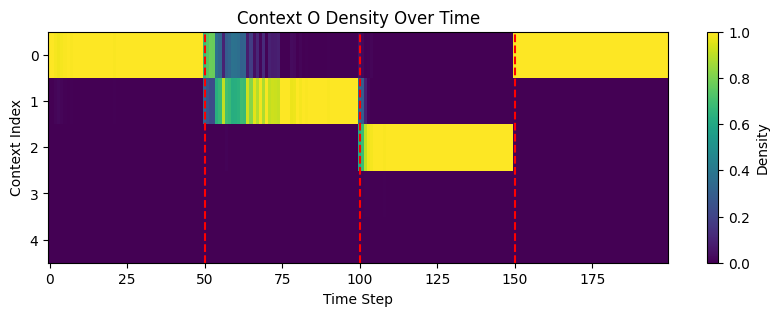

Context R History:


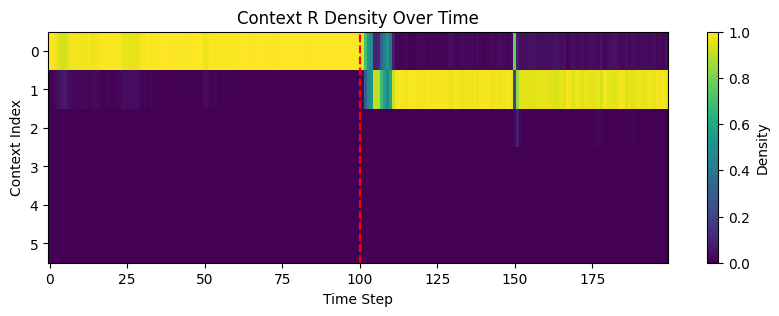

Actions History:


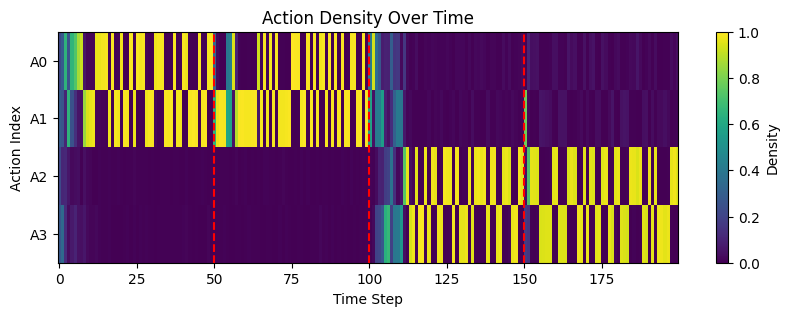

Proportion of Optimal Actions Over Time:


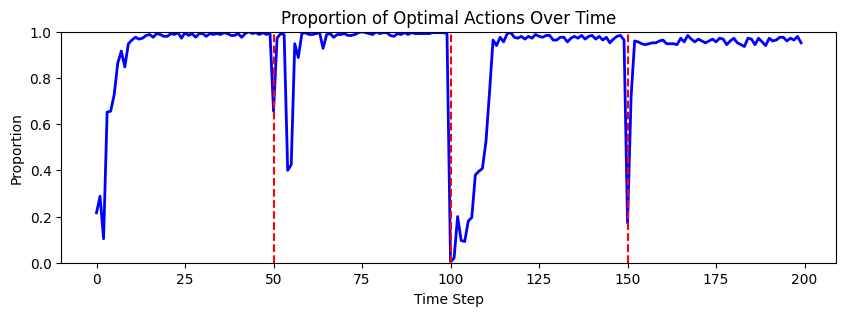

Jump History:


/tmp/ipykernel_3987996/1324857792.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  jumps_densities = torch.tensor(torch.stack(jumps_hist), dtype=torch.float).sum(dim=1) / ensemble.N


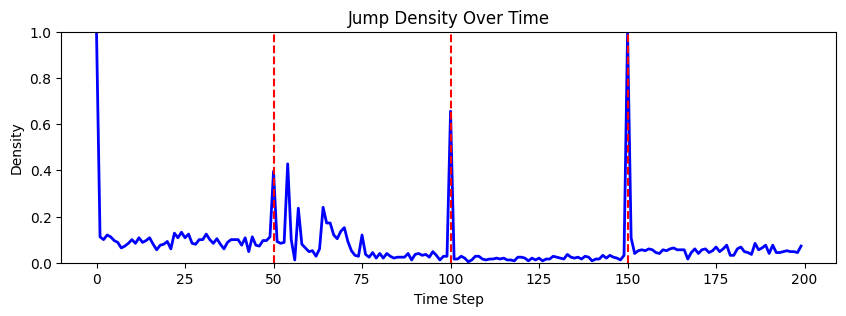

In [10]:
print("Context O History:")
context_o_densities = torch.zeros((len(context_o_hist), 5))
for idx, element in enumerate(context_o_hist):
    #print(element)
    for val in element:
        context_o_densities[idx, val] += 1
context_o_densities = context_o_densities / context_o_densities.sum(dim=1, keepdim=True)

# set size of plot
plt.figure(figsize=(10, 3))
plt.imshow(context_o_densities.T, aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label='Density')
plt.axvline(x=50, color='red', linestyle='--', label='Obs Context Change')
plt.axvline(x=100, color='red', linestyle='--')
plt.axvline(x=150, color='red', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Context Index')
plt.title('Context O Density Over Time')
plt.show()

print("Context R History:")
context_r_densities = torch.zeros((len(context_r_hist), 6))
for idx, element in enumerate(context_r_hist):
    #print(element)
    for val in element:
        context_r_densities[idx, val] += 1
context_r_densities = context_r_densities / context_r_densities.sum(dim=1, keepdim=True)

plt.figure(figsize=(10, 3))
plt.imshow(context_r_densities.T, aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label='Density')
plt.axvline(x=100, color='red', linestyle='--', label='Action Context Change')
plt.xlabel('Time Step')
plt.ylabel('Context Index')
plt.title('Context R Density Over Time')
plt.show()

print("Actions History:")
actions_densities = torch.zeros((len(actions_hist), 4))
for idx, element in enumerate(actions_hist):
    #print(element)
    for val in element:
        actions_densities[idx, val] += 1
actions_densities = actions_densities / actions_densities.sum(dim=1, keepdim=True)

plt.figure(figsize=(10, 3))
plt.imshow(actions_densities.T, aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label='Density')
plt.yticks(ticks=[0, 1, 2, 3], labels=['A0', 'A1', 'A2', 'A3'])
plt.axvline(x=50, color='red', linestyle='--')
plt.axvline(x=100, color='red', linestyle='--')
plt.axvline(x=150, color='red', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Action Index')
plt.title('Action Density Over Time')
plt.show()

print("Proportion of Optimal Actions Over Time:")
true_rewarding_actions = torch.tensor(true_rewarding_actions)
proportion_optimal = torch.zeros(len(actions_hist))
for idx, element in enumerate(actions_hist):
    proportion_optimal[idx] = torch.sum(element == true_rewarding_actions[idx]).item() / len(element)
plt.figure(figsize=(10, 3))
plt.plot(proportion_optimal, label='Proportion Optimal Action', color='blue', linewidth=2)
plt.title('Proportion of Optimal Actions Over Time')
plt.xlabel('Time Step')
plt.ylabel('Proportion')
plt.ylim(0, 1)
plt.axvline(x=50, color='red', linestyle='--')
plt.axvline(x=100, color='red', linestyle='--')
plt.axvline(x=150, color='red', linestyle='--')
plt.show()

print("Jump History:")
jumps_densities = torch.tensor(torch.stack(jumps_hist), dtype=torch.float).sum(dim=1) / ensemble.N


plt.figure(figsize=(10, 3))
plt.plot(jumps_densities, label='Jump', color='blue', linewidth=2)
plt.title('Jump Density Over Time')
plt.xlabel('Time Step')
plt.ylabel('Density')
plt.ylim(0, 1)
plt.axvline(x=50, color='red', linestyle='--')
plt.axvline(x=100, color='red', linestyle='--')
plt.axvline(x=150, color='red', linestyle='--')
plt.show()
